##### Supporting LIbraries

In [27]:
%matplotlib inline

import pandas as pd
import sys
import os
import numpy as np
import matplotlib as plt
plt.style.use('ggplot')

# Question to Explore

* Based on the Data provided, what is the relationship between the Gender (Sex) and Survival?
* Based on the Data provided, what was the distribution of all Embark Ports?
* Based on the Data provided, what was the distribution of Age?

# Investigate

In [28]:
dat=pd.read_csv('titanic_data.csv')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


After exploring the data I realized:
- Age has missing Values
- Cabin has missing Values
- Embarked has missing Values

## Handling Missing/Inconsistent Values

#### Age

For age, I decided to impute it with the Mean Age Grouped by Gender

In [29]:
miss_age=dat[dat['Age'].isnull()]
mean_age=dat.groupby(['Sex'])['Age'].mean()

def age_sub(row):
    if pd.isnull(row['Age']):
        return mean_age[row['Sex']]
    else:
        return row['Age']
dat['Age']=dat.apply(age_sub,axis=1)

dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Confirms we have handled Age properly! :)


#### Limitation

While doing the analysis, I wanted to also explore how the variable "Age" is influence when we impute the Nulls with the Average. In order to see the change I decided to plot the pre-impute vs. Post Impute.

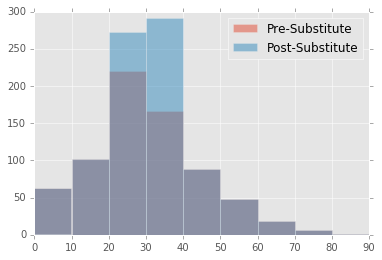

In [30]:
raw=pd.read_csv('titanic_data.csv')

x=raw['Age']
y=dat['Age']

bins=np.linspace(0,90,10)
plt.pyplot.hist(x,bins,alpha=0.5,label='Pre-Substitute')
plt.pyplot.hist(y,bins,alpha=0.5,label='Post-Substitute')
plt.pyplot.legend(loc='best')
plt.pyplot.show()

Based on the histogram above, we see that after substituting/imputing the nulls with the Average. The new Age distribution has the mean overrepresented. Therefore, using a t-test when testing hypothesis will be important so you could make valid causal claims about Age.

#### Embark

Considering that there are only 2 value that are missing I wanted to see if I can substititute with any similarities. 

In [31]:
miss_embark=dat[dat['Embarked'].isnull()]
miss_embark

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Seems like the passengers were travelling together since their ticket number, fare, and Cabin are the same. I decided to look for others who were in the same Cabin + Ticket + Fare 

In [32]:
dat[(dat['Ticket']=='113572') & (dat['Embarked'].notnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


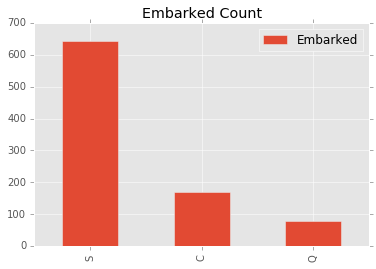

In [33]:
embark_cnt=dat['Embarked'].value_counts()
embark_cnt.plot(kind='bar',title='Embarked Count',legend=True)

See that 'S' is the most popular destination I decided to substitute that for the missing embarked values.

In [34]:
dat['Embarked'].fillna('S',inplace=True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Embarked has been handled!

#### Extra Columns

Since I am not interested in any other columns besides Gender and Survive Info, I devided to drop some extraneous columns.

In [35]:
dat=dat.drop(['Cabin','Pclass','Name','SibSp','Parch','Ticket','Fare'],axis=1)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
Embarked       891 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 34.9+ KB


### Exploration/Analysis

In order to make the calculation easier, I decided to convert the Binary Flag of Survived into a "String" Binary, and create two separate DataFrames (Survivors, Dead)

In [36]:
def change(df):
    #Survive to String Binary
    survive={0: 'Dead', 1: 'Survive'}
    df['Survived'] = df['Survived'].map(survive)
    return df
dat=change(dat)
dat.head()

,PassengerId,Survived,Sex,Age,Embarked
0,1,Dead,male,22.0,S
1,2,Survive,female,38.0,C
2,3,Survive,female,26.0,S
3,4,Survive,female,35.0,S
4,5,Dead,male,35.0,S


In [37]:
survive_dat=dat[dat.Survived=='Survive']
dead_dat=dat[dat.Survived=='Dead']

To Visualize the relationship, I used the Visualization Lib.

Sex       female  male
Survived              
Dead          81   468
Survive      233   109


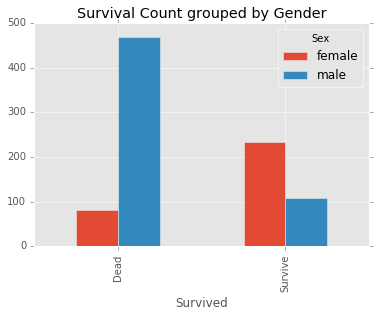

In [38]:
t=pd.crosstab(dat['Survived'],dat['Sex'])
print(t)
t.plot(kind='bar', title='Survival Count grouped by Gender')

To normalize the data and get a cleaner read for each gender, I decided to try another visual that will give the proportion for each gender and their survival category.

             Dead  Survivors
Female  25.796178  74.203822
Male    81.109185  18.890815


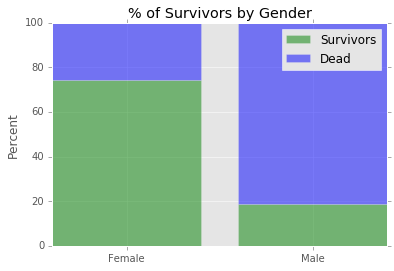

In [39]:
surv_by_gen=survive_dat.groupby(['Sex']).size().values
dead_by_gen=dead_dat.groupby(['Sex']).size().values
tot=surv_by_gen+dead_by_gen
p_1=np.divide(surv_by_gen,tot,dtype='float')*100
p_2=np.divide(dead_by_gen,tot,dtype='float')*100

df= {'Survivors': pd.Series(p_1, index=['Female','Male']),
    'Dead': pd.Series(p_2,index=['Female','Male'])}

df=pd.DataFrame(df)
print(df)

# Generate Visual
gen=['Female','Male']
f,ax=plt.pyplot.subplots()
ax.bar(range(len(p_1)),p_1, color='g',alpha=0.5, label='Survivors')
ax.bar(range(len(p_2)),p_2, bottom=p_1,color='b',alpha=0.5,label='Dead')
plt.pyplot.sca(ax)
plt.pyplot.xticks([0.4,1.4],gen)
plt.pyplot.xlabel("")
plt.pyplot.ylabel("Percent")
plt.pyplot.legend(loc='best')
plt.pyplot.title('% of Survivors by Gender')

Based on the calculations above, one can clearly see that Females had a higher proportion of Survivals than the males.